### Initializations

Import third-party and built-in modules

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import pathlib

Import the fertilization module

In [2]:
from fertilization import *

Define folder for files output (adapt as needed)

In [3]:
base_dir = pathlib.Path(".").resolve()

Make sure that `.svg` exports have editable texts

In [4]:
old_fonttype = plt.rcParams['svg.fonttype']

In [5]:
plt.rcParams['svg.fonttype'] = 'none'

## Hybridization

Two species of sea urchins: green (index 0) and purple (index 1)

### Case (a): normal

#### Male factors

Speed: green urchin at 88 μm/s, purple urchin at 145 μm/s

In [6]:
v_green_gd = 88E-6
v_purple_gd = 145E-6

In [7]:
def v_sperm_gd(t):
    return np.array([v_green_gd, v_purple_gd])

Proportion motile: constant at 0.8 for BOTH

In [8]:
d_const = 0.0
motile_gd = 0.8

In [9]:
def d_sperm(t):
    return np.array([d_const, d_const])

Concentration of sperms ranges logrithmically from 10 sperms per mL to 100000 sperms per mL

In [10]:
# 10**(1+6) to 10**(5+6)
Sinit_array = np.logspace(1 + 6, 5 + 6, (5 - 1) * 16 + 1, base=10)

#### Female factors

Diameter: green urchin 145 μm, purple urchin 84 μm [as usual, $\sigma_0 = \pi (D/2)^2$] 

In [11]:
D_green_gd = 145E-6
D_purple_gd = 84E-6

In [12]:
sigma0_gd = np.pi * (0.5 * np.array([D_green_gd, D_purple_gd]))**2

In [13]:
print("area: green = {:.5e} m^2, purple = {:.5e} m^2".format(sigma0_gd[0], sigma0_gd[1]))

area: green = 1.65130e-08 m^2, purple = 5.54177e-09 m^2


Concentration: 50 eggs per mL total, equal proportion for each

In [14]:
Einit_sum = 50E6

In [15]:
Einit = 0.5 * Einit_sum * np.array([1,1])

#### Common / combined factors

Probability of fertilization given hit (fertilizability): 0.1 when male and female matches; 0.1 for purple sperm and green egg, 0.0 for green sperm and purple egg.

_Note_ that fertilizability is now a 2-by-2 matrix. Moreoever, row (0-th axis) corresponds to sperm while column (1-st axis) corresponds to eggs.

In [16]:
alpha_const = np.array([[0.1, 0], [0.1, 0.1]])

In [17]:
def a_egg(t):
    return alpha_const

Fertilization time: 1 hour = 60 minutes = 3600 seconds

In [18]:
t_end = 60 * 60 # = 60 minutes
t_array = np.arange(t_end / 4, t_end + 1, t_end / 4)

#### Numerical computation

Initialize arrays for $S_0$, $E_*$, and $S_{1,*}$

In [19]:
S0_array_gd = np.zeros([2, Sinit_array.size, t_array.size])
Eany_array_gd = np.zeros([2, Sinit_array.size, t_array.size])
S1a_array_gd =  np.zeros([2, 2, Sinit_array.size, t_array.size])

Loop through sperm concentration.

_Note_ that the array of concentration correponds total concentration (i.e., sum of green and purple urchin sperms), hence an additional factor of 0.5. Also note that `S_init` corresponds to _motile_ sperm concentration, and so there is also a factor of `motile_gd`.

In [20]:
for _i, _S in enumerate(Sinit_array):
    model = FertilizationModel(
        v_sperm_gd, d_sperm, 0.5 * _S * motile_gd * np.array([1, 1]),
        a_egg, sigma0_gd, Einit,
        t_end
    )
    model.solve_S0()
    model.solve_pmn()
    S0_array_gd[:, _i, :] = model.S0(t_array)
    Eany_array_gd[:, _i, :] = model.E_any(t_array)
    S1a_array_gd[:, :, _i, :] = model.S_ord(t_array, 1)

Calculate proportion of free live sperms, fertilized eggs, and succeeding sperms

In [21]:
norm_S0_gd = S0_array_gd / Sinit_array[np.newaxis, :, np.newaxis]
norm_Eany_gd = Eany_array_gd / Einit[:, np.newaxis, np.newaxis]
norm_S1a_gd = S1a_array_gd / Einit[np.newaxis, :, np.newaxis, np.newaxis]

Plot proportion of eggs fertilized as function of sperm concentration, and save the resulting figure.

_Note_ that the _sum_ of purple-green and green proportion should approach 1 at high sperm concentration

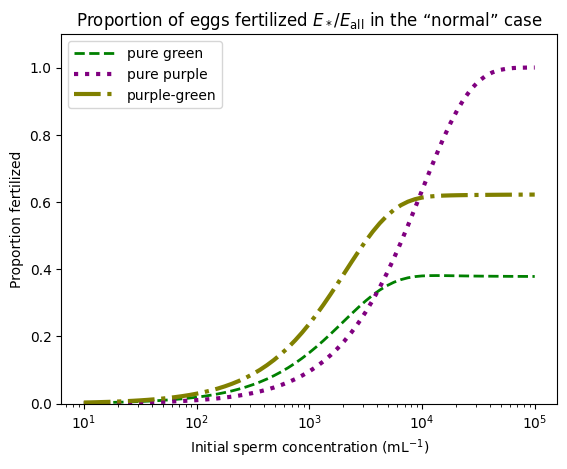

In [22]:
plt.plot(
    1E-6 * Sinit_array, norm_S1a_gd[0, 0, :, -1], lw=2, ls="--",
     c="green", label="pure green"
)
plt.plot(
    1E-6 * Sinit_array, norm_S1a_gd[1, 1, :, -1], lw=3, ls=":",
    c="purple", label="pure purple"
)
plt.plot(
    1E-6 * Sinit_array, norm_S1a_gd[1, 0, :, -1], lw=3, ls="-.",
    c="olive", label="purple-green"
)

plt.title("Proportion of eggs fertilized $E_* / E_\\text{all}$ in the “normal” case")
plt.xscale("log")
#plt.yscale("log")
plt.ylim([0, 1.1])
plt.xlabel("Initial sperm concentration (mL$^{-1}$)")
plt.ylabel("Proportion fertilized")
plt.legend(loc="upper left", handlelength=3)

plt.savefig(base_dir / 'prop_fert_normal.svg')
plt.savefig(base_dir / 'prop_fert_normal.pdf')

plt.show()

Plot proportion of free-live sperm as function of sperm concentration (figure not saved)

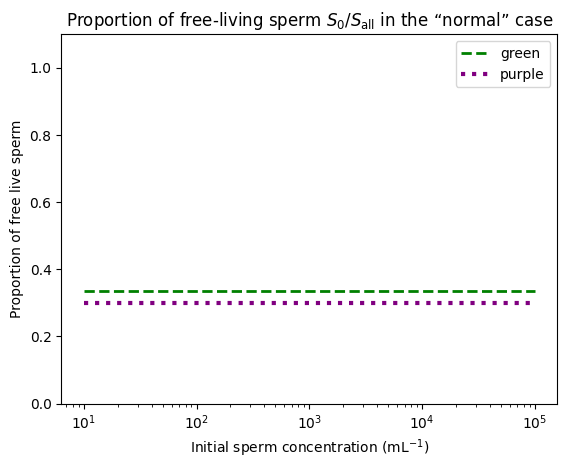

In [23]:
plt.plot(
    1E-6 * Sinit_array, norm_S0_gd[0, :, -1], lw=2, ls="--",
    c="green", label="green"
)
plt.plot(
    1E-6 * Sinit_array, norm_S0_gd[1, :, -1], lw=3, ls=":",
    c="purple", label="purple"
)

plt.title("Proportion of free-living sperm $S_0 / S_\\text{all}$ in the “normal” case")
plt.xscale("log")
#plt.yscale("log")
plt.ylim([0,1.1])
plt.xlabel("Initial sperm concentration (mL$^{-1}$)")
plt.ylabel("Proportion of free live sperm")
plt.legend()

plt.show()

### Case (b): reduced

#### Male factors

5% reduction on both speed and % motile for purple urchin sperms; 10% reduction similarly for green urchin sperms

In [24]:
v_green_bd = v_green_gd * 0.9
v_purple_bd = v_purple_gd * 0.95

green_motile = motile_gd * 0.9
purple_motile = motile_gd * 0.95

d_const = 0.0

In [25]:
print("speed: green = {:.5e}, purple = {:.5e}".format(v_green_bd, v_purple_bd))
print("% motion: green = {:.5f}, purple = {:.5f}".format(green_motile, purple_motile))

speed: green = 7.92000e-05, purple = 1.37750e-04
% motion: green = 0.72000, purple = 0.76000


In [26]:
def v_sperm_bd(t):
    return np.array([v_green_bd, v_purple_bd])

def d_sperm(t):
    return np.array([d_const, d_const])

#### Female factors

5% reduction on diameter of purple urchin eggs; 10% reduction similarly for green urchin eggs

In [27]:
D_green_bd = D_green_gd * 0.9
D_purple_bd = D_purple_gd * 0.95

In [28]:
sigma0_bd = np.pi * (0.5 * np.array([D_green_bd, D_purple_bd]))**2

In [29]:
print("diameter: green = {:.5e}, purple = {:.5e}".format(D_green_bd, D_purple_bd))

diameter: green = 1.30500e-04, purple = 7.98000e-05


In [30]:
print("area: green = {:.5e}, purple = {:.5e}".format(sigma0_bd[0], sigma0_bd[1]))

area: green = 1.33755e-08, purple = 5.00145e-09


#### Numerical computation

In [31]:
S0_array_bd = np.zeros([2, Sinit_array.size, t_array.size])
Eany_array_bd = np.zeros([2, Sinit_array.size, t_array.size])
S1a_array_bd =  np.zeros([2, 2, Sinit_array.size, t_array.size])

In [32]:
for _i, _S in enumerate(Sinit_array):
    model = FertilizationModel(
        v_sperm_bd, d_sperm, 0.5 * _S * np.array([green_motile, purple_motile]),
        a_egg, sigma0_bd, Einit,
        t_end
    )
    model.solve_S0()
    model.solve_pmn()
    S0_array_bd[:, _i, :] = model.S0(t_array)
    Eany_array_bd[:, _i, :] = model.E_any(t_array)
    S1a_array_bd[:, :, _i, :] = model.S_ord(t_array, 1)

In [33]:
norm_S0_bd = S0_array_bd / Sinit_array[np.newaxis, :, np.newaxis]
norm_Eany_bd = Eany_array_bd / Einit[:, np.newaxis, np.newaxis]
norm_S1a_bd = S1a_array_bd / Einit[np.newaxis, :, np.newaxis, np.newaxis]

Plot proportion of eggs fertilized as function of sperm concentration in the stressed case, and save the resulting figure.

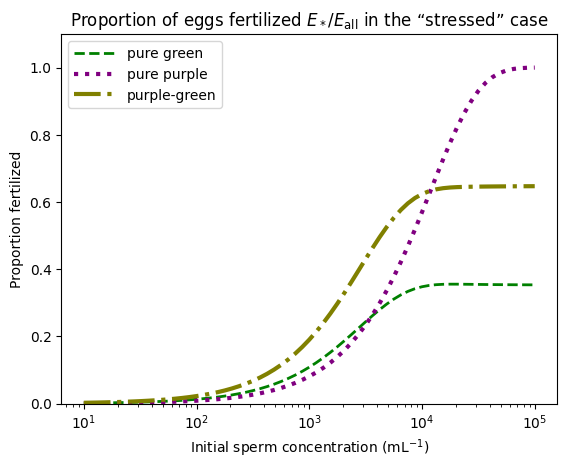

In [34]:
plt.plot(
    1E-6 * Sinit_array, norm_S1a_bd[0, 0, :, -1], lw=2, ls="--",
     c="green", label="pure green"
)
plt.plot(
    1E-6 * Sinit_array, norm_S1a_bd[1, 1, :, -1], lw=3, ls=":",
    c="purple", label="pure purple"
)
plt.plot(
    1E-6 * Sinit_array, norm_S1a_bd[1, 0, :, -1], lw=3, ls="-.",
    c="olive", label="purple-green"
)

plt.title("Proportion of eggs fertilized $E_* / E_\\text{all}$ in the “stressed” case")
plt.xscale("log")
#plt.yscale("log")
plt.ylim([0, 1.1])
plt.xlabel("Initial sperm concentration (mL$^{-1}$)")
plt.ylabel("Proportion fertilized")
plt.legend(loc="upper left", handlelength=3)

plt.savefig(base_dir / 'prop_fert_stressed.svg')
plt.savefig(base_dir / 'prop_fert_stressed.pdf')

plt.show()

Plot proportion of free-live sperms as function of sperm concentration in the stressed case (figure not saved)

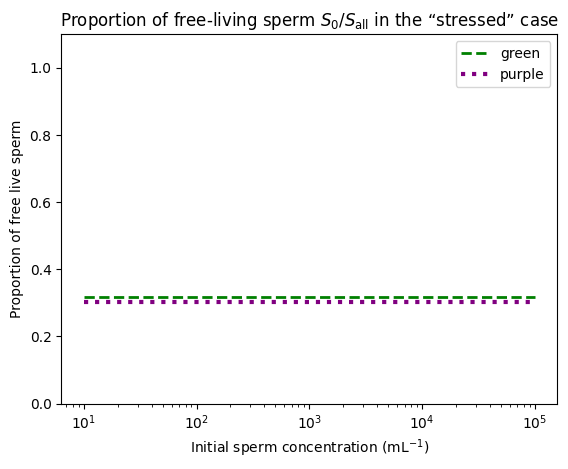

In [35]:
plt.plot(
    1E-6 * Sinit_array, norm_S0_bd[0, :, -1], lw=2, ls="--",
    c="green", label="green"
)
plt.plot(
    1E-6 * Sinit_array, norm_S0_bd[1, :, -1], lw=3, ls=":", 
    c="purple", label="purple"
)

plt.title("Proportion of free-living sperm $S_0 / S_\\text{all}$ in the “stressed” case")
plt.xscale("log")
#plt.yscale("log")
plt.ylim([0,1.1])
plt.xlabel("Initial sperm concentration (mL$^{-1}$)")
plt.ylabel("Proportion of free live sperm")
plt.legend()

plt.show()

### Comparing results

Compute the ratio of $S_{1,*}$ in the stressed case to the normal case (and do the same for normal / normal)

_Note_: the [0,1] component of the 2-by-2 $S_{1,*}$ ratio gives zero-over-zero and thus produces warning. The warning can be ignored since we'll never consider the [0,1] component

In [36]:
ratio_S1a_gd = norm_S1a_gd / norm_S1a_gd
ratio_S1a_bd = norm_S1a_bd / norm_S1a_gd

C:\Users\wingho\AppData\Local\Temp\ipykernel_25012\4044438575.py:1: RuntimeWarning: invalid value encountered in divide
  ratio_S1a_gd = norm_S1a_gd / norm_S1a_gd
C:\Users\wingho\AppData\Local\Temp\ipykernel_25012\4044438575.py:2: RuntimeWarning: invalid value encountered in divide
  ratio_S1a_bd = norm_S1a_bd / norm_S1a_gd


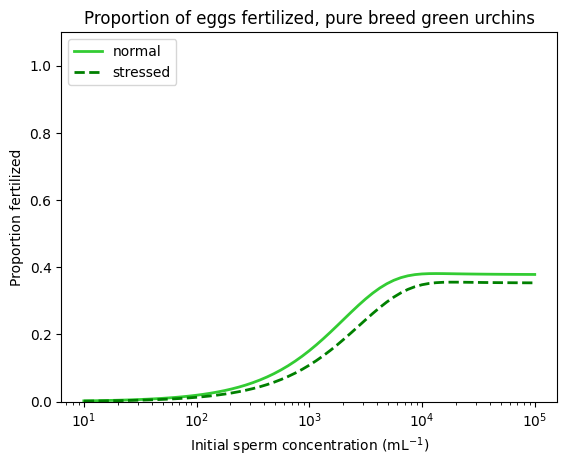

In [37]:
plt.plot(
    1E-6 * Sinit_array, norm_S1a_gd[0, 0, :, -1], lw=2, 
     c="#3c3", label="normal"
)
plt.plot(
    1E-6 * Sinit_array, norm_S1a_bd[0, 0, :, -1], lw=2, ls="--",
    c="green", label="stressed"
)

plt.title("Proportion of eggs fertilized, pure breed green urchins")
plt.xscale("log")
#plt.yscale("log")
plt.ylim([0, 1.1])
plt.xlabel("Initial sperm concentration (mL$^{-1}$)")
plt.ylabel("Proportion fertilized")
plt.legend(loc="upper left")

plt.savefig(base_dir / 'compare_green.svg')
plt.savefig(base_dir / 'compare_green.pdf')

plt.show()

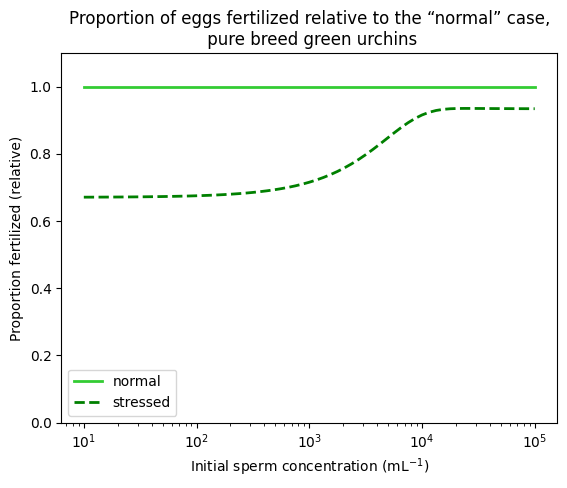

In [38]:
plt.plot(
    1E-6 * Sinit_array, ratio_S1a_gd[0, 0, :, -1], lw=2, 
     c="#3c3", label="normal"
)
plt.plot(
    1E-6 * Sinit_array, ratio_S1a_bd[0, 0, :, -1], lw=2, ls="--",
    c="green", label="stressed"
)

plt.title("Proportion of eggs fertilized relative to the “normal” case,\n pure breed green urchins")
plt.xscale("log")
#plt.yscale("log")
plt.ylim([0, 1.1])
plt.xlabel("Initial sperm concentration (mL$^{-1}$)")
plt.ylabel("Proportion fertilized (relative)")
plt.legend()

plt.savefig(base_dir / 'ratio_green.svg')
plt.savefig(base_dir / 'ratio_green.pdf')

plt.show()

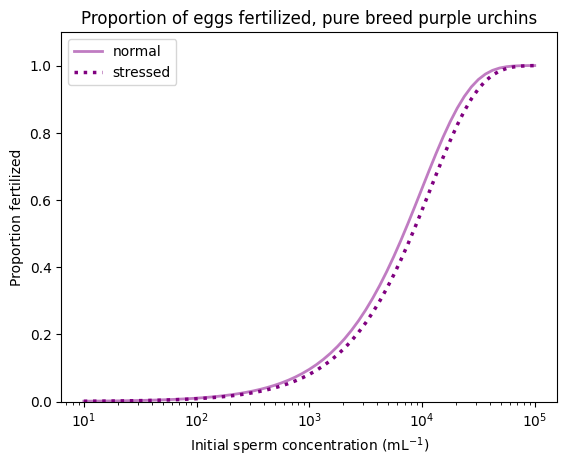

In [39]:
plt.plot(
    1E-6 * Sinit_array, norm_S1a_gd[1, 1, :, -1], lw=2, 
    c="#c07cc2", label="normal"
)
plt.plot(
    1E-6 * Sinit_array, norm_S1a_bd[1, 1, :, -1], lw=2.5, ls=":",
    c="purple", label="stressed"
)

plt.title("Proportion of eggs fertilized, pure breed purple urchins")
plt.xscale("log")
#plt.yscale("log")
plt.ylim([0, 1.1])
plt.xlabel("Initial sperm concentration (mL$^{-1}$)")
plt.ylabel("Proportion fertilized")
plt.legend(loc="upper left")

plt.savefig(base_dir / 'compare_purple.svg')
plt.savefig(base_dir / 'compare_purple.pdf')

plt.show()

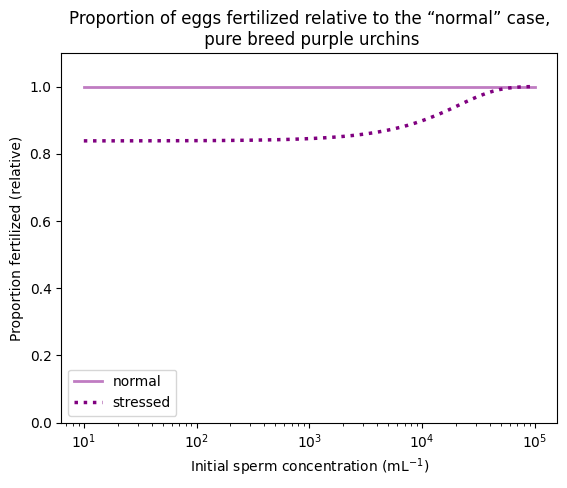

In [40]:
plt.plot(
    1E-6 * Sinit_array, ratio_S1a_gd[1, 1, :, -1], lw=2, 
    c="#c07cc2", label="normal"
)
plt.plot(
    1E-6 * Sinit_array, ratio_S1a_bd[1, 1, :, -1], lw=2.5, ls=":",
    c="purple", label="stressed"
)

plt.title("Proportion of eggs fertilized relative to the “normal” case,\n pure breed purple urchins")
plt.xscale("log")
#plt.yscale("log")
plt.ylim([0, 1.1])
plt.xlabel("Initial sperm concentration (mL$^{-1}$)")
plt.ylabel("Proportion fertilized (relative)")
plt.legend()

plt.savefig(base_dir / 'ratio_purple.svg')
plt.savefig(base_dir / 'ratio_purple.pdf')

plt.show()

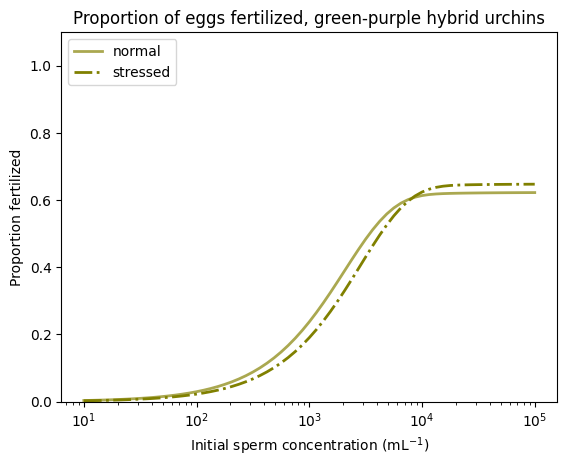

In [41]:
plt.plot(
    1E-6 * Sinit_array, norm_S1a_gd[1, 0, :, -1], lw=2, 
    c="#aaa850", label="normal"
)
plt.plot(
    1E-6 * Sinit_array, norm_S1a_bd[1, 0, :, -1], lw=2, ls="-.",
    c="olive", label="stressed"
)

plt.title("Proportion of eggs fertilized, green-purple hybrid urchins")
plt.xscale("log")
#plt.yscale("log")
plt.ylim([0, 1.1])
plt.xlabel("Initial sperm concentration (mL$^{-1}$)")
plt.ylabel("Proportion fertilized")
plt.legend(loc="upper left")

plt.savefig(base_dir / 'compare_hybrid.svg')
plt.savefig(base_dir / 'compare_hybrid.pdf')

plt.show()

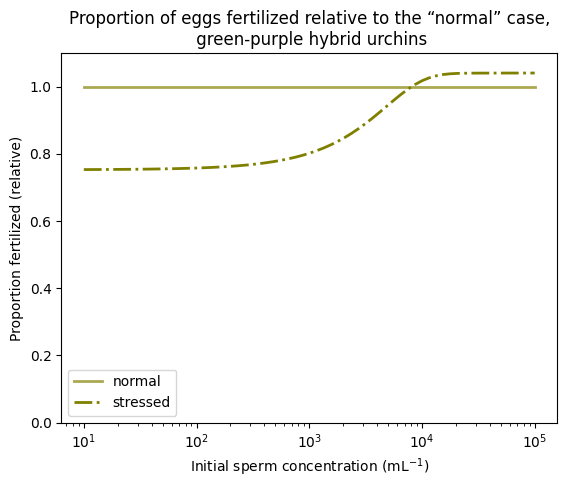

In [42]:
plt.plot(
    1E-6 * Sinit_array, ratio_S1a_gd[1, 0, :, -1], lw=2, 
     c="#aaa850", label="normal"
)
plt.plot(
    1E-6 * Sinit_array, ratio_S1a_bd[1, 0, :, -1], lw=2, ls="-.",
    c="olive", label="stressed"
)

plt.title("Proportion of eggs fertilized relative to the “normal” case,\n green-purple hybrid urchins")
plt.xscale("log")
#plt.yscale("log")
plt.ylim([0, 1.1])
plt.xlabel("Initial sperm concentration (mL$^{-1}$)")
plt.ylabel("Proportion fertilized (relative)")
plt.legend()

plt.savefig(base_dir / 'ratio_hybrid.svg')
plt.savefig(base_dir / 'ratio_hybrid.pdf')

plt.show()

## Saving results

Construct the correct sperm concentration and time point labels for serialized numpy arrays

In [43]:
S_grid, t_grid = np.meshgrid(
    Sinit_array, t_array, indexing='ij'
)

Construct dataframes for the proportion fertilized data in both normal and stressed condition

In [44]:
df_gd = pd.DataFrame({
    "time (s)": t_grid.ravel(),
    "Sinit (m^-3)": S_grid.ravel(),
    "S0 green": norm_S0_gd[0, :, :].ravel(),
    "S0 purple": norm_S0_gd[1, :, :].ravel(),
    "E_* green": norm_Eany_gd[0, :, :].ravel(),
    "E_* purple": norm_Eany_gd[1, :, :].ravel(),
    "S_{1,*} green": norm_S1a_gd[0, 0, :, :].ravel(),
    "S_{1,*} purple": norm_S1a_gd[1, 1, :, :].ravel(),
    "S_{1,*} hybrid": norm_S1a_gd[1, 0, :, :].ravel(),
})
df_bd = pd.DataFrame({
    "time (s)": t_grid.ravel(),
    "Sinit (m^-3)": S_grid.ravel(),
    "S0 green": norm_S0_bd[0, :, :].ravel(),
    "S0 purple": norm_S0_bd[1, :, :].ravel(),
    "E_* green": norm_Eany_bd[0, :, :].ravel(),
    "E_* purple": norm_Eany_bd[1, :, :].ravel(),
    "S_{1,*} green": norm_S1a_bd[0, 0, :, :].ravel(),
    "S_{1,*} purple": norm_S1a_bd[1, 1, :, :].ravel(),
    "S_{1,*} hybrid": norm_S1a_bd[1, 0, :, :].ravel(),
})

Write to Excel (with each dataframe a separate sheet)

In [45]:
with pd.ExcelWriter('hybrid.xlsx', mode='w') as writer:  
    df_gd.to_excel(writer, sheet_name='normal', index=False)
    df_bd.to_excel(writer, sheet_name='stressed', index=False)

Record the relevant parameters used and save to file

In [46]:
param_str = f'''
v_green_gd = {v_green_gd}
v_purple_gd = {v_purple_gd}
motile_gd = {motile_gd}

v_green_bd = {v_green_gd}
v_purple_bd = {v_purple_gd}
motile_green_bd = {green_motile}
motile_purple_bd = {purple_motile}

d_sperm = {d_const}

sigma0_green_gd = {sigma0_gd[0]}
sigma0_purple_gd = {sigma0_gd[1]}

sigma0_green_bd = {sigma0_bd[0]}
sigma0_purple_bd = {sigma0_bd[1]}

Einit_green = {Einit[0]}
Einit_purple = {Einit[1]}

alpha_gg = {alpha_const[0,0]}
alpha_pp = {alpha_const[1,1]}
alpha_pg = {alpha_const[1,0]}

t_end = {t_end}
'''

In [47]:
with open(base_dir / "hybrid_params.txt", "w") as outfile:
    outfile.write(param_str)